In [1]:
import numpy as np
import scipy.constants
import LaserParameters, BBOParameters

import matplotlib
import matplotlib.pyplot as plt

In [2]:
plt.style.use('dark_background')
savedir = '/workspaces/BBO-Optimal-Parameters/plots/'

## Introduction

## Birefrigency

In [3]:
sellmeier_eq = {'book': BBOParameters.n2_Nikogosyan, 'book_NIR': BBOParameters.n2_Nikogosyan_NIR, 'eksma': BBOParameters.n2_eksma }

In [4]:
n_values = {}
wavelengths = np.linspace(.250, 2, 100)
for key in sellmeier_eq:
    n02, ne2 = sellmeier_eq[key](wavelengths)
    n_values[key] = {'lambda': wavelengths, 'no': np.sqrt(n02), 'ne': np.sqrt(ne2) }

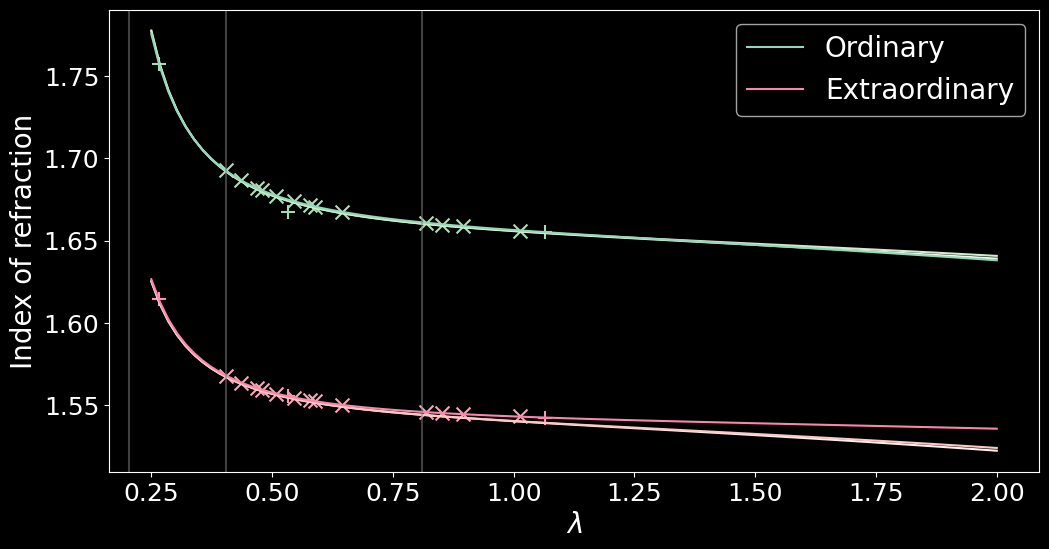

In [5]:
cmap_n0 = matplotlib.colormaps['GnBu']
cmap_ne = matplotlib.colormaps['RdPu']
i = 0 

plt.figure(figsize = (12,6))

for key in n_values:
    n0 = n_values[key]['no']
    ne = n_values[key]['ne']
    if i==2: 
        label_no = "Ordinary"
        label_ne = 'Extraordinary'
    else: label_no=None; label_ne = None; 
    plt.plot(wavelengths, n0, color = cmap_n0(50*i+10), label = label_no)
    plt.plot(wavelengths, ne, color = cmap_ne(50*i+10), label = label_ne)
    i+=1


plt.scatter(BBOParameters.ExperimentalValues_1.wavelength, BBOParameters.ExperimentalValues_1.no, color = cmap_n0(90), marker = 'x', s =100)
plt.scatter(BBOParameters.ExperimentalValues_2.wavelength, BBOParameters.ExperimentalValues_2.no, color = cmap_n0(100), marker = '+', s=100)

plt.scatter(BBOParameters.ExperimentalValues_1.wavelength, BBOParameters.ExperimentalValues_1.ne, color = cmap_ne(90), marker = 'x', s =100)
plt.scatter(BBOParameters.ExperimentalValues_2.wavelength, BBOParameters.ExperimentalValues_2.ne, color = cmap_ne(100), marker = '+', s=100)

plt.axvline( x = 0.810, color = 'gray',alpha = 0.5)
plt.axvline( x = 0.405, color = 'gray',alpha = 0.5)
plt.axvline( x = 0.203, color = 'gray',alpha = 0.5)

plt.xlabel('$\lambda$', fontsize = 20)
plt.ylabel('Index of refraction', fontsize = 20)
plt.legend(loc='best', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## Phase Matching

In [6]:
wavelengths = np.linspace(0.3, 2.5, 100)

/workspaces/BBO-Optimal-Parameters/BBOParameters.py:44: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(argument)*180/np.pi #, np.arcsin(-argument)*180/np.pi


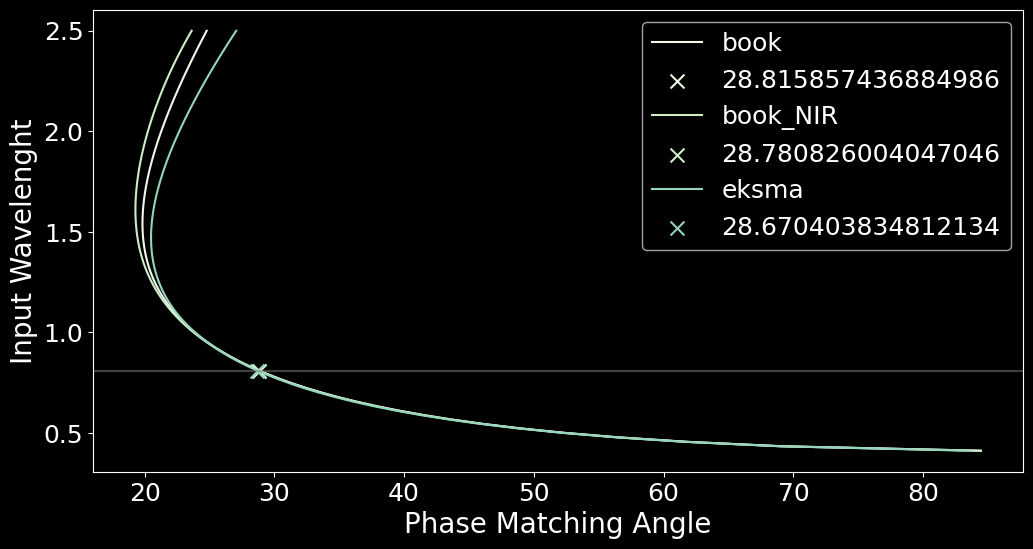

In [7]:
cmap = matplotlib.colormaps['GnBu']
i = 0 

plt.figure(figsize = (12,6))


for key in sellmeier_eq:
    no2_w, ne2_w = sellmeier_eq[key](wavelengths)
    no2_2w, ne2_2w = sellmeier_eq[key](0.5*wavelengths)
    
    pm_anlges_positive = BBOParameters.PhaseMatchingAngle(no2_w, ne2_w, no2_2w, ne2_2w)
    plt.plot(pm_anlges_positive, wavelengths, color = cmap(50*i+10), label=key)
    #plt.plot(pm_anlges_positive, 0.05*BBOParameters.deffTypeI(pm_anlges_positive, 90, -47))

    no2_w, ne2_w = sellmeier_eq[key](0.810)
    no2_2w, ne2_2w = sellmeier_eq[key](0.5*0.810)
    pm_anlges_positive = BBOParameters.PhaseMatchingAngle(no2_w, ne2_w, no2_2w, ne2_2w)

    plt.scatter(pm_anlges_positive, .810, color = cmap(50*i+10), marker = 'x', s = 100, label = pm_anlges_positive)
    
    i+=1

plt.axhline( y = 0.810, color = 'gray',alpha = 0.5)
#plt.ylim([0,2.5])
plt.xlabel('Phase Matching Angle', fontsize = 20)
plt.ylabel('Input Wavelenght', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig(savedir+'phasematch.png', bbox_inches = 'tight')
plt.show()

## Thickness optimization

### Effective second order nonlinear coefficient

### Loading all the physical constants

In [18]:
c = scipy.constants.c
epsilon_0 = scipy.constants.epsilon_0

In [19]:
Laser810 = LaserParameters.MiraLaser()
#deffTypeI = BBOParameters.deffTypeI

In [20]:
def RungeKutta4(F, t, y0, *args):
    N = len(t)
    h = t[1] - t[0]

    y = np.zeros( (N, len(y0)) )
    y[0] = y0
    for j in range(N-1):
        k1 = F(y[j], t[j], *args)
        k2 = F(y[j] + k1*h/2., t[j] + h/2., *args)
        k3 = F(y[j] + k2*h/2., t[j] + h/2., *args)
        k4 = F(y[j] + k3*h, t[j] + h, *args)
        y[j+1] = y[j] + (h/6.)*(k1 + 2*k2 + 2*k3 + k4)
                 
    return y

In [35]:
def SHG_RungeKuttaFunction(t, y, Delta_s):
    v1 = y[0]*y[1]*np.sin(y[2])
    v2 = -y[0]**2*np.sin(y[2])
    v3 = Delta_s+np.cos(y[2])*(2*y[1]**2-y[0]**2)/y[1]
    
    return np.array([v1,v2,v3])

In [22]:
no2_1550, ne2_1550 = BBOParameters.n2_Nikogosyan(1.55)
no2_775, ne2_775 = BBOParameters.n2_Nikogosyan(0.775)

#theta = 19.32*np.pi/180
theta = BBOParameters.PhaseMatchingAngle(no2_1550, ne2_1550, no2_775, ne2_775)
phi = -90*np.pi/180

n_1550 = np.sqrt(no2_1550)#ne_angle(no2_1550, ne2_1550, theta)
n_775 = BBOParameters.ne_angle(no2_775, ne2_775, theta)

omega_1550 = 2*np.pi*scipy.constants.lambda2nu(1550e-9)
Delta_K = 2*omega_1550*(n_1550 - n_775)/c

Power = Laser810.peak_power
Waist = 0.01e-3
I = Power/(np.pi*Waist**2) #needs improvement
d_eff = 4e-11*BBOParameters.deffTypeI(theta, phi, -0.5) #needs improvement

characteristic_length = np.sqrt(2*n_1550**2*n_775/(epsilon_0*c*I))*c/(2*omega_1550*np.abs(d_eff))

In [23]:
u_tot = 1
u1_0 = 0.999
u2_0 = np.sqrt(u_tot**22-u1_0**2)
y0 = np.array([u1_0,u2_0,0])
z = np.linspace(0,3, int(1e5))
Delta_s = 0.05

SHG_Solution = RungeKutta4(SHG_RungeKuttaFunction, z, y0, Delta_s )

In [24]:
u1 = SHG_Solution[:,0]
u2 = SHG_Solution[:,1]
alpha = SHG_Solution[:,2]

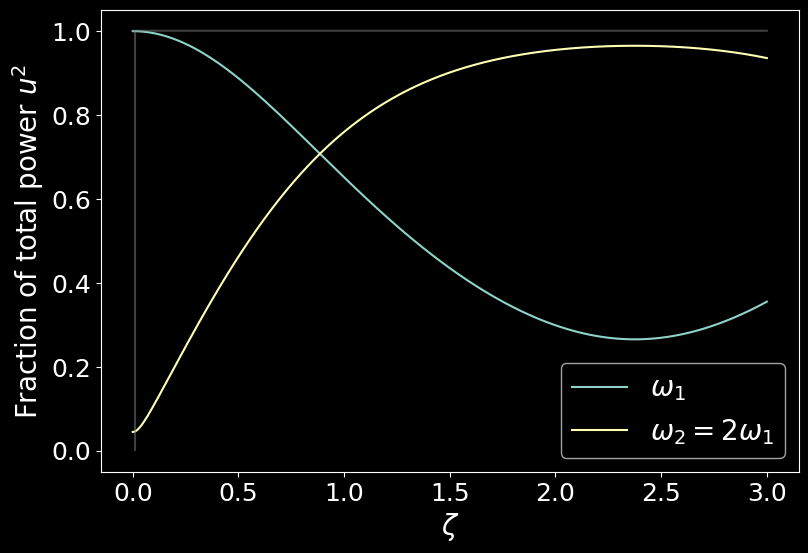

In [25]:
plt.figure(figsize=(9,6))

L = 1e-3/characteristic_length

plt.plot(z, u1, label = r'$\omega_1$')
plt.plot(z,u2, label=r'$\omega_2=2 \omega_1$')
plt.plot(z, u1**2+u2**2, color = 'gray', alpha = 0.5)
plt.vlines(L, 0, 1, color = 'gray', alpha = 0.5)

plt.legend(loc='best', fontsize=20)
plt.xlabel(r'$\zeta$', fontsize = 20)
plt.ylabel(r'Fraction of total power $u^2$', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig(savedir+'SHG_BBOTheoretical.png', bbox_inches='tight')
plt.show()

In [36]:
y0 = np.array([u1_0,u2_0,0])
scipy.integrate.solve_ivp(SHG_RungeKuttaFunction, t_span = (0, len(z)), y0 = y0, method='RK45', args = (Delta_s,) )

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.303e-05 ...  1.000e+05  1.000e+05]
        y: [[ 9.990e-01  9.990e-01 ...  6.766e-02  6.551e-02]
            [ 4.471e-02  4.471e-02 ...  5.753e-02  5.996e-02]
            [ 0.000e+00 -1.398e-03 ...  5.803e+03  5.803e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 697580
     njev: 0
      nlu: 0